In [4]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../path_planning_prob")
sys.path.insert(0, "../utils")

#path planning prob
from path_planning_problem import PathPlanningProblem
from goal_region import GoalRegion

#So we can import my local libs
import CommChannel as CC
import qos
from importlib import reload 

import pointcloud as PC
from obstacles import ObstacleMod, PolyObstacle, AccelerationCap, SpectralEfficiencyCap

In [5]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 6#any of 2, 4, 6, or 8
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-77.90174759231485
SNR Threshold: 27


In [6]:
reload(CC)
#generate a single, simple channel
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 49
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.75

qBase = [2,3]

x_max = 20
x_min = 0
y_max = 20
y_min = 0
v_max = 8
v_min = -8
data = 40#kb 

a_max = 3
r_max = 8
region = [x_max, x_min, y_max, y_min]


cp = CC.ChannelParams(qBase, nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP)


#res = 2/decorrMP
res = 10
p_th = 0.5
#create the true channel
true_channel = CC.CommChannel(cp, region, res)
true_channel.generateSH();true_channel.generateMP(2)
BW = 1.5#2KHz


pct_sample = 0.01#1% sampling
n_samples = int(pct_sample*(region[0] - region[1])*(region[2] - region[3])*res**2)
print('Drawing %d samples'%(n_samples))
xs, vals = true_channel.sampleChannel(n_samples)
pred_channel = CC.PredictedChannel(cp, region, res, xs, vals)
pred_channel.setPth(p_th)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Drawing 400 samples


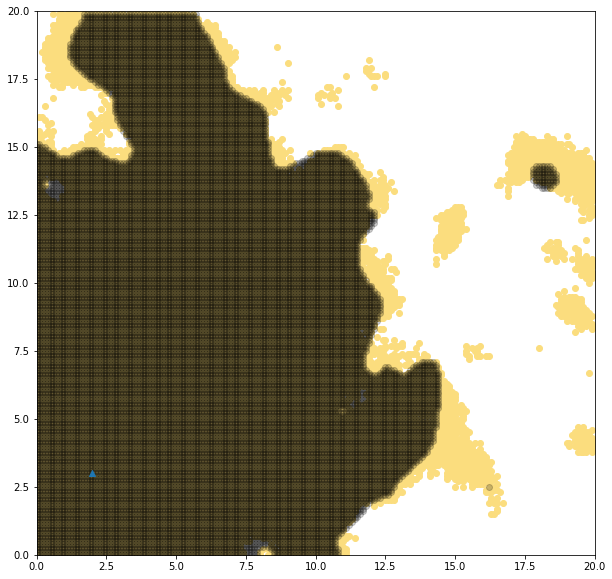

In [7]:
cc = true_channel
pc = pred_channel
gamma_th = GAMMA_TH
fig = plt.figure(figsize=(10,10))
true_points = cc.getConnectedPoints(gamma_th)
plt.scatter(true_points[:,0], true_points[:,1], color='xkcd:wheat')
pred_points = pc.getConnectedPoints(gamma_th)
plt.scatter(pred_points[:,0], pred_points[:,1], color='k', alpha=0.2)
plt.xlim((cc.region[1], cc.region[0]))
plt.ylim((cc.region[3], cc.region[2]))
plt.scatter([qBase[0]], [qBase[1]], marker='^')

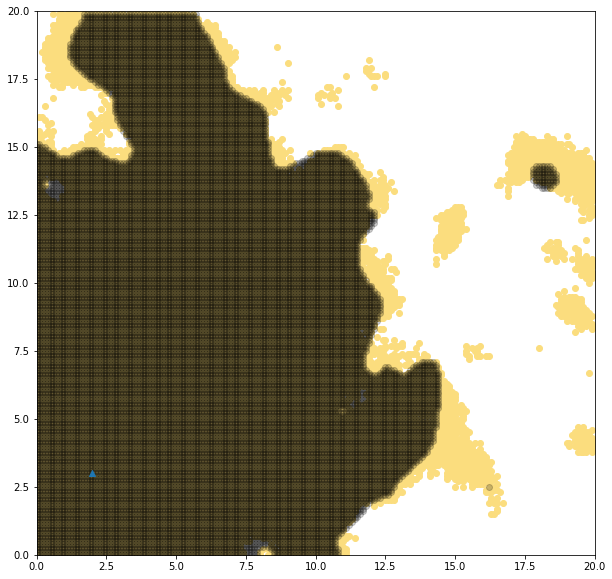

In [8]:
fig = plt.figure(figsize=(10,10))
plt.scatter(true_points[:,0], true_points[:,1], color='xkcd:wheat')
plt.scatter(pred_points[:,0], pred_points[:,1], color='k', alpha=0.2)
plt.xlim((cc.region[1], cc.region[0]))
plt.ylim((cc.region[3], cc.region[2]))
plt.scatter([qBase[0]], [qBase[1]], marker='^')

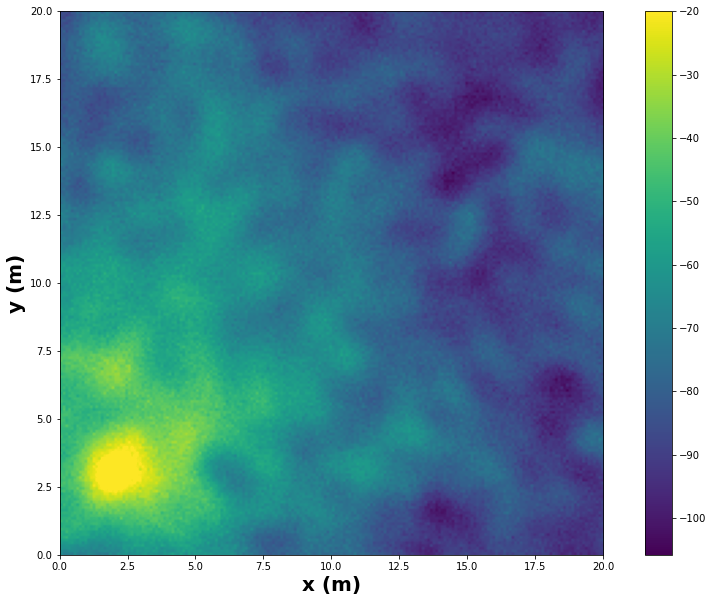

In [9]:
#first, just work with the true channel
cc.plot_channel(twod=True)

In [10]:
from motion import LinearMotionPower
from misc import split_seg_by_time
from qos import QoSReq
def energy(n1, n2, channel, BW, k1, k2, ber, rx_noise):
    #calculate motion energy
    x1 = n1.x; x2 = n2.x;
    dist = np.linalg.norm(x1[:2] - x2[:2])
    v_avg = np.linalg.norm(x1[2:4] + x2[2:4])/2
    time = dist/v_avg
    a = np.linalg.norm(x1[2:4] - x2[2:4])/time
    motion_energy = LinearMotionPower(k1, k2, v_avg)*time
    
    #calculate comm energy
    r = (x1[4] - x2[4])/(time*BW)
    comm_energy = 0
    if r>0:
        qos = QoSReq(ber, r, rx_noise)
        dt = 0.1
        path = split_seg_by_time(x1[:2], x2[:2], x1[2:4], x2[2:4], time, dt=dt)
        pl = len(path)

        for i in range(1,pl):
            txPower_s = channel.getReqTXPowerAtPoint(path[i-1], qos)
            txPower_f = channel.getReqTXPowerAtPoint(path[i], qos)
            #then look at the power in watts
            comm_energy += (txPower_s+txPower_f).W*dt/2
    #what if we just make this comm_energy
    #return motion_energy + comm_energy
    return comm_energy
        



In [11]:
import obstacles as OB
reload(OB)
source = np.array([0,18, 0, 0, data])
dests = np.array([[18,0, 0, 0, 0]])

goal_region = PC.PointCloud(dests)
goal_region.polygons = [PC.Poly(np.array([[18.5, 0.5],[18.5, -0.5],[17.5, -0.5],[17.5, 0.5]]))]
obstacle_mod = ObstacleMod([OB.PolyObstacle(np.array([[12,10],[9,7],[12,7]])),
                           OB.SpectralEfficiencyCap(r_max, BW),
                          OB.AccelerationCap(a_max)])
#cost_func= lambda n1, n2: np.linalg.norm(n1.x - n2.x)
k1 = 7.2; k2 = 0.29
cost_func = lambda n1, n2: energy(n1, n2, cc, BW, k1, k2, BER, rx_noise)

In [12]:
problem_region = [*region, v_max, v_min, v_max, v_min, data, 0]
pppi = PathPlanningProblem(problem_region, source, GoalRegion(goal_region), obstacle_mod, cost_func)

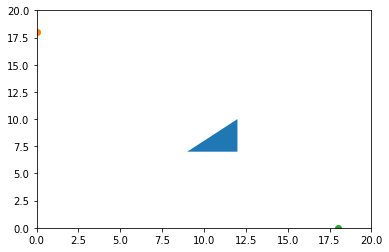

In [13]:
pppi.plotProb()

In [14]:
sys.path.insert(0, "../rrt")
import rd_tree as RDT
from sampler import SamplerType, Sampler
from stop_criteria import StopCriteria
import pbin
import rrange
reload(rrange)
reload(pbin)
reload(RDT)
mins = 5
seconds = mins*60
stop = StopCriteria(solution_required = True, max_run_time=seconds)
smplr = Sampler(SamplerType.UNIRAND, 30)
do_rewire = True
steer_rad = 3
solver = RDT.RDTSolver(smplr, stop, do_rewire, steer_rad)

../rrt\rd_tree.py:97: RuntimeWarning: invalid value encountered in double_scalars
  gamma = (2*(1+1/d)*(lb_ms/lb_unit_ball))**(1/d) + 1#need to make it greater
../path_planning_prob\obstacles.py:190: RuntimeWarning: divide by zero encountered in double_scalars
  time = 2*dist/np.linalg.norm(v1+v2) #assume linear, constant acceleration
../path_planning_prob\obstacles.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  time = 2*dist/np.linalg.norm(v1+v2) #assume linear, constant acceleration
C:\Users\wdurh\Documents\research\comm aware robotics\Code\python\rrt\../geometry\CoordTransforms.py:70: UserWarning: Some points are outside of the region
  warnings.warn('Some points are outside of the region')


sampled new
[ 0 18  0  0 40]
[18  0  0  0  0]
[[ 0.         18.          0.          0.         40.        ]
 [ 1.13892626 16.86107374  0.          0.         37.46905276]]
[[ 0. 18.  0.  0. 40.]]
new node not added
sampled new
[ 0 18  0  0 40]
[15.51479272 16.6479705  -6.04093344 -3.06593514  4.18767035]
sampled new
[ 1.17431794 17.8976646  -0.45723953 -0.23206128 37.2893572 ]
[12.6251427   6.86529602 -1.75308198  3.33274032 27.42358646]
sampled new
[ 2.97350574 16.16422589 -0.66084617  0.328051   35.73921782]
[18.51983336  7.82308905  2.54707135 -6.4098307  22.96275225]
sampled new
[ 4.99900929 15.07747391 -0.24289226 -0.5498157  34.07459471]
[ 5.94780833 16.19914712  2.23567094 -1.0681774  28.49448097]
5
sampled new
[ 5.45071586 15.61148284  0.93710818 -0.79659861 31.4180005 ]
[ 6.70333952 18.40010492  4.41087245  7.71221603 10.01437655]
[[ 5.45071586 15.61148284  0.93710818 -0.79659861 31.4180005 ]
 [ 5.61067196 15.96758112  1.38069696  0.28995029 28.68482495]]
[[ 5.45071586 15.611

sampled new
[12.94310217 14.0069326   1.91352218 -0.24938932 10.811768  ]
[12.58482726 17.88692548  5.72956437 -5.635744   10.811768  ]
[[12.94310217 14.0069326   1.91352218 -0.24938932 10.811768  ]
 [12.80288369 15.52545006  3.40701118 -2.3574534  10.811768  ]]
[[12.94310217 14.0069326   1.91352218 -0.24938932 10.811768  ]]
new node not added
sampled new
[5.96102969e+00 1.21837268e+01 1.22258679e-01 1.40403196e-02
 2.64704376e+01]
[ 8.37064052  8.97822584  1.93804583 -0.91344598 26.47043755]
[[ 5.96102969e+00  1.21837268e+01  1.22258679e-01  1.40403196e-02
   2.64704376e+01]
 [ 7.56788234e+00  1.00461336e+01  1.33311910e+00 -6.04455331e-01
   2.64704376e+01]]
[[5.96102969e+00 1.21837268e+01 1.22258679e-01 1.40403196e-02
  2.64704376e+01]]
new node not added
sampled new
[ 3.70066395 14.45333837  0.98391167 -2.92674901 31.18074878]
[ 7.20166072  4.66105306  6.19185043 -3.69903236 31.18074878]
[[ 3.70066395 14.45333837  0.98391167 -2.92674901 31.18074878]
 [ 4.60173568 11.93304143  2.324

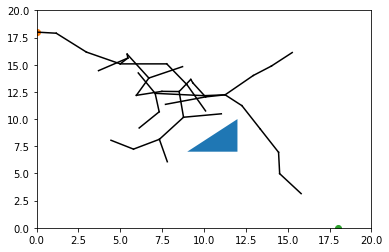

sampled new
[ 8.71924387 14.82239115 -0.75622457 -3.4846821  26.60403783]
[ 9.83408663 17.58191693 -3.24384166 -3.94413745 23.53038425]
[[ 8.71924387 14.82239115 -0.75622457 -3.4846821  26.60403783]
 [ 9.39213759 16.48797812 -2.25769364 -3.76199889 24.74885047]]
[[ 8.71924387 14.82239115 -0.75622457 -3.4846821  26.60403783]]
new node not added
sampled new
[ 8.9842777  13.1634351  -2.8936768   0.51223085 33.17506415]
[10.98495363 12.20676568 -1.04078494 -2.31727434 33.17506415]
[[ 8.9842777  13.1634351  -2.8936768   0.51223085 33.17506415]
 [10.46830928 12.45381111 -1.51926629 -1.58659735 33.17506415]]
[[ 8.9842777  13.1634351  -2.8936768   0.51223085 33.17506415]]
new node not added
sampled new
[11.0364443  10.48519862 -1.57159999  2.55544964 20.12881985]
[16.99687136  2.46417476 -6.99046263  5.4385907  20.12881985]
[[11.0364443  10.48519862 -1.57159999  2.55544964 20.12881985]
 [12.56114283  8.43339207 -2.9577644   3.29296742 20.12881985]]
[[11.0364443  10.48519862 -1.57159999  2.5554

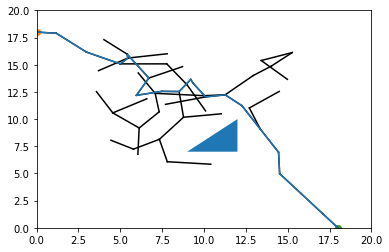

sampled new
[ 7.70138013 11.35445956 -0.9335555  -1.02071423 12.36737188]
[11.26160211 12.60968875 -7.60584347 -0.65116722 12.36737188]
[[ 7.70138013 11.35445956 -0.9335555  -1.02071423 12.36737188]
 [ 9.09298428 11.84509811 -3.54159054 -0.87626729 12.36737188]]
[[ 7.70138013 11.35445956 -0.9335555  -1.02071423 12.36737188]]
new node not added
sampled new
[10.09467597 10.75094477 -2.09466281  1.65390021 33.10383376]
[ 5.68200738  8.51669771 -3.94071942  7.42286962 33.10383376]
[[10.09467597 10.75094477 -2.09466281  1.65390021 33.10383376]
 [ 8.40183687  9.893817   -2.80286846  3.86705916 33.10383376]]
[[10.09467597 10.75094477 -2.09466281  1.65390021 33.10383376]]
new node not added
sampled new
[10.09467597 10.75094477 -2.09466281  1.65390021 33.10383376]
[16.39341002 10.60481428 -6.42414894 -2.98179481 33.10383376]
[[10.09467597 10.75094477 -2.09466281  1.65390021 33.10383376]
 [12.20826679 10.70190951 -3.54745667  0.0983555  33.10383376]]
[[10.09467597 10.75094477 -2.09466281  1.6539

C:\Users\wdurh\Documents\research\comm aware robotics\Code\python\rrt\../geometry\CoordTransforms.py:70: UserWarning: Some points are outside of the region
  warnings.warn('Some points are outside of the region')



new node not added
sampled new
[5.96102969e+00 1.21837268e+01 1.22258679e-01 1.40403196e-02
 2.64704376e+01]
[ 5.89212709  9.946427    3.98910063  3.35853367 26.47043755]
[[5.96102969e+00 1.21837268e+01 1.22258679e-01 1.40403196e-02
  2.64704376e+01]
 [5.92399240e+00 1.09811084e+01 2.20080678e+00 1.81180977e+00
  2.64704376e+01]]
[[5.96102969e+00 1.21837268e+01 1.22258679e-01 1.40403196e-02
  2.64704376e+01]]
new node not added
sampled new
[12.71015877 11.02300731  0.30719349 -2.42547453  5.05605173]
[10.6018405  12.38722482  2.11085908 -5.34383677  4.10651829]
[[12.71015877 11.02300731  0.30719349 -2.42547453  5.05605173]
 [11.2582645  11.96247627  1.54928856 -4.43520591  4.40215512]]
[[12.71015877 11.02300731  0.30719349 -2.42547453  5.05605173]]
new node not added
sampled new
[12.76319056 11.05731853 -0.97689537  1.96273477 32.44022081]
[19.9658669  16.40104899  2.18262117 -6.12872983 32.44022081]
[[ 1.27631906e+01  1.10573185e+01 -9.76895370e-01  1.96273477e+00
   3.24402208e+01]


sampled new
[4.31052323 7.60433782 1.31099049 1.77082043 5.81142173]
[0.53445751 3.88338485 4.65866153 6.69782295 5.81142173]
[[4.31052323 7.60433782 1.31099049 1.77082043 5.81142173]
 [2.88990096 6.20444994 2.57044315 3.62444534 5.81142173]]
[[4.31052323 7.60433782 1.31099049 1.77082043 5.81142173]]
new node not added
sampled new
[ 7.831752   14.2476723  -0.57512638  1.0073418  14.42687221]
[ 3.15964992 19.37144383 -2.88747198 -0.82153091 14.42687221]
[[ 7.831752   14.2476723  -0.57512638  1.0073418  14.42687221]
 [ 5.97154384 16.28771369 -1.49579209  0.27917194 14.42687221]]
[[ 7.831752   14.2476723  -0.57512638  1.0073418  14.42687221]]
new node not added
sampled new
[ 3.70066395 14.45333837  0.98391167 -2.92674901 31.18074878]
[ 0.60662977  8.7458422   2.37379794 -2.1203716  31.18074878]
[[ 3.70066395 14.45333837  0.98391167 -2.92674901 31.18074878]
 [ 2.31280907 11.89319328  1.60735677 -2.56504169 31.18074878]]
[[ 3.70066395 14.45333837  0.98391167 -2.92674901 31.18074878]]
new no

sampled new
[ 4.31146269  4.22861541  1.5087468   0.12263626 28.83610431]
[ 1.18414503  0.56448516  3.65377415  5.60789856 28.83610431]
[[ 4.31146269  4.22861541  1.5087468   0.12263626 28.83610431]
 [ 3.07843755  2.78393815  2.3544788   2.2853415  28.83610431]]
[[ 4.31146269  4.22861541  1.5087468   0.12263626 28.83610431]]
new node not added
345
sampled new
[ 8.9842777  13.1634351  -2.8936768   0.51223085 33.17506415]
[ 6.25698076  8.78589567 -7.82744737 -5.81226668 33.17506415]
[[ 8.9842777  13.1634351  -2.8936768   0.51223085 33.17506415]
 [ 8.12631073 11.78632644 -4.44576749 -1.47736181 33.17506415]]
[[ 8.9842777  13.1634351  -2.8936768   0.51223085 33.17506415]]
new node not added
sampled new
[ 8.5315655   7.13864667 -1.60249871  1.30313841 10.56633566]
[ 7.01615492  4.78917249 -2.79377988  3.3886192  10.56633566]
[[ 8.5315655   7.13864667 -1.60249871  1.30313841 10.56633566]
 [ 7.29810945  5.22631136 -2.57213228  3.00059845 10.56633566]]
[[ 8.5315655   7.13864667 -1.60249871  1.

[[ 7.80946589  6.0768062   0.37605932  3.06837938 17.92491285]
 [ 6.50185345  5.57688848  2.75960711  4.2179577  17.73151794]]
[[ 7.80946589  6.0768062   0.37605932  3.06837938 17.92491285]]
new node not added
sampled new
[16.97397745 14.55963233 -2.34871059 -1.39211695  7.63066692]
[17.39342977 14.00173159 -4.55652025 -5.93964846  7.63066692]
[[16.97397745 14.55963233 -2.34871059 -1.39211695  7.63066692]
 [17.22056408 14.23165498 -3.64663247 -4.06550893  7.63066692]]
[[16.97397745 14.55963233 -2.34871059 -1.39211695  7.63066692]]
new node not added
sampled new
[ 8.71924387 14.82239115 -0.75622457 -3.4846821  26.60403783]
[ 7.30064881 15.28373201 -4.83615774 -7.84161948 26.60403783]
[[ 8.71924387 14.82239115 -0.75622457 -3.4846821  26.60403783]
 [ 8.02753431 15.0473418  -2.74560749 -5.60913278 26.60403783]]
[[ 8.71924387 14.82239115 -0.75622457 -3.4846821  26.60403783]]
new node not added
sampled new
[ 4.99900929 15.07747391 -0.24289226 -0.5498157  34.07459471]
[ 4.23703606 10.99492556

KeyboardInterrupt: 

In [15]:
solver.solve(pppi)

101
isLeaf: False
isLeaf: True[array([10.93142414, 13.32589501,  3.11699923, -1.3623518 , 20.99905855]), array([12.24340451, 12.78772582,  3.67291868, -0.38726437, 18.60547556]), array([13.9593495 , 14.28295624,  2.98087916, -0.1322838 , 16.79553496]), array([14.44439556, 12.88713873,  1.67081606,  0.62527079, 14.66803185]), array([15.19997896, 12.02410079,  1.63226539, -0.58438564, 12.17413842]), array([12.8999031 , 11.16471711,  1.52356827, -2.21210065, 11.61750614]), array([13.79399521,  9.20744342,  1.25647327, -1.82429983,  9.58085452]), array([15.44901374,  8.87346122,  0.07200024, -0.18056924,  8.15097938]), array([11.62895861, 12.73426444, -0.34655788, -3.17710963, 10.91564637]), array([15.45233532,  7.4267617 , -1.69182251, -1.47039225,  6.69072755]), array([16.17635066,  5.31616628, -1.21102711, -1.05252464,  4.78930409]), array([13.2171516 , 14.33152041, -1.01807329, -2.63308491,  9.13252536]), array([ 1.30882095e+01,  1.62092538e+01, -1.60087891e-03, -5.57075941e-01,
      

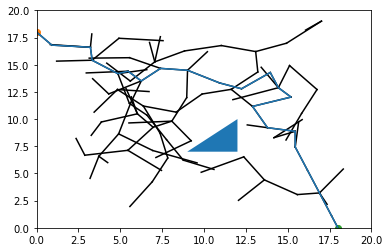

In [22]:
print(solver.rdTree.treeNodes.count)
tnodes = solver.rdTree.treeNodes
print(tnodes.root)
print(tnodes.root.left)
print(tnodes.root.right)

root = solver.getRoot()
bsf = solver.getBSF()
root.plotTree(style='k-')
bsf.pathToRoot(do_plot=True)
pppi.plotProb()

In [34]:
print(bsf)

x: [18.  0.  0.  0.  0.]
cost to here: [20.18798037]
Num Kids: 0


In [35]:
#OK now let's figure out a good way to plot this
path = bsf.pathToRoot()

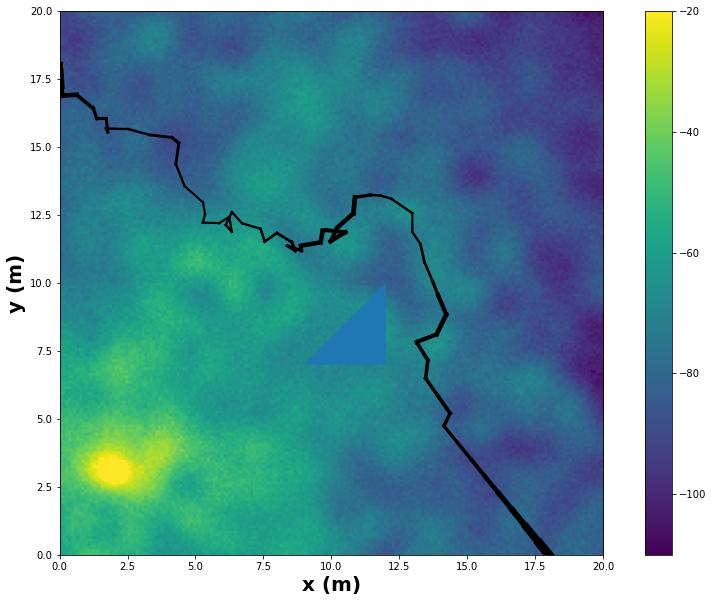

In [36]:
cc.plot_channel(twod=True)
pppi.plotProb()

vs = np.linalg.norm(path[:,2:4], axis=1)
x = path[:,0]
y = path[:,1]
n = len(path)
base_width=10
for i in range(n-1):
    plt.plot(x[i:i+2], y[i:i+2], 'k', linewidth = 10/(1+vs[i]+vs[i+1]))